# Filter public/charter school data into team-specific data sets

Author(s): Jaren Haber<br>
Project Manager: Jaren Haber, PhD Candidate <br>
Contact: jhaber@berkeley.edu

Institution: University of California, Berkeley <br>
Program: Undergraduate Research Apprentice Program (URAP) <br>

Date created: Nov. 27, 2018<br>
Last modified: Jan. 20, 2019

Description: Loads most recent charter data, filters to key variables, converts the DF for efficiency, reorders & renames variables, and saves data specifically for statistics and geospatial teams.

## Initialize

### Import packages & functions

In [1]:
import pandas as pd # For working with DataFrames
import ast # For working with strings
import numpy as np # For numerical things
import re # For cleaning webtext

# For loading functions from files in data_tools directory:
import sys; sys.path.insert(0, "../../data_management/tools/")

In [2]:
# For displaying basic DF info, storing DFs for memory efficiency, and loading a filtered DF:
from df_tools import check_df, convert_df, load_filtered_df, replace_df_nulls

# For quickly loading & saving pickle files in Python:
from quickpickle import quickpickle_dump, quickpickle_load 

# For saving and loading text lists to/from file:
from textlist_file import write_list, load_list 

# For calculating densities, years opened and closed, and school closure rates:
from df_calc import count_pdfs, density_calc, openclose_calc, closerate_calc

### Define file paths

In [9]:
# Input files:
charters_path = "../../nowdata/charters_2015.pkl"
pubschools_path = "../../nowdata/pubschools_2015.pkl"
edfacts_folder = "../../nowdata/edfacts/"

charters_small_loc = "../../nowdata/backups/charters_parsed_03-04_no-text_SMALL.csv"
ACSsmall_loc = "../../nowdata/backups/ACS_2016_sd-merged_SMALL.csv"
ACSfull_loc = "../../nowdata/backups/ACS_2016_sd-merged_FULL.csv"
SAIPE_loc = "../../nowdata/backups/SAIPE_2016_sd.txt"

In [10]:
# Output files:
charters_storepath = "../../nowdata/backups/charters_full_2015_250_v2a.pkl"
pubschools_storepath = "../../nowdata/backups/pubschools_full_2015_CRDC.pkl"

geo_storepath = "../../nowdata/backups/charters_geo_2015_v2a.csv"
geoteam_path = "../../geospatial/data/charters_geo_2015_v2a.csv"

stats_storepath = "../../nowdata/backups/charters_stats_2015_v2a.csv"
stats_text_storepath = "../../nowdata/backups/charters_statstext_2015_v2a.pkl"

## Load & filter data

In [5]:
# ACS (school district) data
acs = pd.read_csv(ACSfull_loc, header = [0, 1], encoding="latin1", low_memory=False) # School district social data (ACS, 2012-16)
print(acs.shape)
list(acs)

(13406, 126)


[('FIPS', 'Geo_FIPS'),
 ('Name of Area', 'Geo_NAME'),
 ('Qualifying Name', 'Geo_QName'),
 ('State/U.S.-Abbreviation (USPS)', 'Geo_STUSAB'),
 ('Summary Level', 'Geo_SUMLEV'),
 ('File Identification', 'Geo_FILEID'),
 ('Logical Record Number', 'Geo_LOGRECNO'),
 ('State (FIPS)', 'Geo_STATE'),
 ('School District (Elementary)', 'Geo_SDELM'),
 ('School District (Secondary)', 'Geo_SDSEC'),
 ('School District (Unified)', 'Geo_SDUNI'),
 ('Geographic Identifier', 'Geo_GEOID'),
 ('Area (Land)', 'Geo_AREALAND'),
 ('Area (Water)', 'Geo_AREAWATR'),
 ('Total Population', 'SE_T002_001'),
 ('Population Density (Per Sq. Mile)', 'SE_T002_002'),
 ('Area (Land)', 'SE_T002_003'),
 ('% Total Population: Under 18 Years', 'PCT_SE_T009_002'),
 ('% Total Population: 18 to 34 Years', 'PCT_SE_T009_003'),
 ('% Total Population: 35 to 64 Years', 'PCT_SE_T009_004'),
 ('% Total Population: 65 and Over', 'PCT_SE_T009_005'),
 ('% Total Population: White Alone', 'PCT_SE_T013_002'),
 ('% Total Population: Black or African 

In [6]:
# Small charters data set (previously used for geospatial)
charters_smalldf = load_filtered_df(charters_small_loc, [])

# rows and cols:  (6972, 32)
# duplicates by NCESSCH: 0

Columns and # missing cases (if any): 
STATENAME
LEAID
LEA_NAME
NCESSCH
SCH_NAME
TOTFRL: 218 missing
AM: 218 missing
AS: 218 missing
BL: 218 missing
HI: 218 missing
HP: 218 missing
MEMBER: 218 missing
TR: 218 missing
TITLEI: 624 missing
FTE: 218 missing
YEAR_OPENED: 70 missing
YEAR_CLOSED: 6484 missing
LATCODE: 114 missing
LONGCODE: 114 missing
LOCALE: 114 missing
ALL_MTH00PCTPROF_1415: 688 missing
ALL_RLA00PCTPROF_1415: 688 missing
ADDRESS14
ess_count: 1596 missing
prog_count: 1596 missing
rit_count: 1596 missing
ess_strength: 2016 missing
prog_strength: 2014 missing
AGE: 70 missing
PCTETH: 259 missing
PLACE: 114 missing
TOTETH: 218 missing


In [7]:
# Load full public school data set - just the cols needed to count density
pubdf_small = load_filtered_df(pubschools_path, ["NCESSCH", "GEO_LEAID", "LEAID", "TRUE_CHARTER", "SY_STATUS15", "YEAR_OPENED", "YEAR_CLOSED"])

# rows and cols:  (136825, 7)
# duplicates by NCESSCH: 0

Columns and # missing cases (if any): 
NCESSCH
GEO_LEAID: 34502 missing
LEAID: 36593 missing
TRUE_CHARTER
SY_STATUS15: 34699 missing
YEAR_OPENED: 2789 missing
YEAR_CLOSED: 105477 missing


In [12]:
# Add to pub schools LEA_NAME from original data
pubadd = pd.read_csv("../../nowdata/ccd_csvs/ccd_sch_029_1516_w_2a_011717.csv", usecols=["NCESSCH", "LEA_NAME"], encoding = "latin1", low_memory=False)
pubdf_small = pd.merge(pubdf_small, pubadd, how="left", on="NCESSCH")
check_df(pubdf_small, "NCESSCH")

# rows and cols:  (136825, 8)
# duplicates by NCESSCH: 0

Columns and # missing cases (if any): 
NCESSCH
GEO_LEAID: 34502 missing
LEAID: 36593 missing
TRUE_CHARTER
SY_STATUS15: 34699 missing
YEAR_OPENED: 2789 missing
YEAR_CLOSED: 105477 missing
LEA_NAME: 34424 missing


In [13]:
# Define variables to keep from full charter data set
keepvars = ['WEBTEXT', 'LEVEL', 'MEMBER', 'SE_T002_002', 'TOTETH', 'TOTFRL', 'PCT_SE_T113_002', 
            'WH', 'AM', 'AS', 'BL', 'HI', 'HP', 'TR', 
            'ESS_VALID_RATIO', 'PROG_VALID_RATIO', 'INQUIRY_RATIO', 'DISCIPLINE_RATIO', 'TITLEI', 'FTE', 
            'INQUIRY_COUNT', 'DISCIPLINE_COUNT', 'NUMWORDS', 'LSTATE', 'CMO_NAME', 'NUMPAGES', 
            'NCESSCH', 'SY_STATUS15', 'SCHNAM15', 'LAT1516', 'LON1516', 'ADDRESS16', 'LEAID', 'GEO_LEAID']

statusyears_list = ['STATUS98', 'STATUS99', 'STATUS00', 'STATUS01', 'STATUS02', 'STATUS03', 
                    'STATUS04', 'STATUS05', 'STATUS06', 'STATUS07', 'STATUS08', 'STATUS09', 
                    'STATUS10', 'STATUS11', 'STATUS12', 'STATUS13', 'SY_STATUS', 'SY_STATUS15', 'SY_STATUS16']

expul_cols = ['TOT_DISCWODIS_EXPWE_M', 'TOT_DISCWODIS_EXPWE_F', 'TOT_DISCWODIS_EXPWOE_M', 
              'TOT_DISCWODIS_EXPWOE_F', 'TOT_DISCWDIS_EXPWE_IDEA_M', 'TOT_DISCWDIS_EXPWE_IDEA_F', 
              'TOT_DISCWDIS_EXPWOE_IDEA_M', 'TOT_DISCWDIS_EXPWOE_IDEA_F']

crime_cols = ['TOT_DISCWODIS_REF_M', 'TOT_DISCWODIS_REF_F', 'TOT_DISCWDIS_REF_IDEA_M', 'TOT_DISCWDIS_REF_IDEA_F', 
              'SCH_OFFENSE_RAPE', 'SCH_OFFENSE_BATT', 'SCH_OFFENSE_ROBWW', 'SCH_OFFENSE_ROBWX', 'SCH_OFFENSE_ROBWOW', 
              'SCH_OFFENSE_ATTWW', 'SCH_OFFENSE_ATTWX', 'SCH_OFFENSE_ATTWOW', 'SCH_OFFENSE_THRWW', 'SCH_OFFENSE_THRWX', 
              'SCH_OFFENSE_THRWOW', 'SCH_OFFENSE_POSSWX']

retention_cols = ['TOT_RET_KG_M', 'TOT_RET_KG_F', 'TOT_RET_G01_M', 'TOT_RET_G01_F', 'TOT_RET_G02_M', 'TOT_RET_G02_F', 
                  'TOT_RET_G03_M', 'TOT_RET_G03_F', 'TOT_RET_G04_M', 'TOT_RET_G04_F', 'TOT_RET_G05_M', 'TOT_RET_G05_F', 
                  'TOT_RET_G06_M', 'TOT_RET_G06_F', 'TOT_RET_G07_M', 'TOT_RET_G07_F', 'TOT_RET_G08_M', 'TOT_RET_G08_F', 
                  'TOT_RET_G09_M', 'TOT_RET_G09_F', 'TOT_RET_G10_M', 'TOT_RET_G10_F', 'TOT_RET_G11_M', 'TOT_RET_G11_F', 
                  'TOT_RET_G12_M', 'TOT_RET_G12_F']

other_cols = ['TOT_LEPENR_M', 'TOT_LEPENR_F', 'TOT_IDEAENR_M', 'TOT_IDEAENR_F', 'TOT_504ENR_M', 
              'TOT_504ENR_F', 'TOT_GTENR_M', 'TOT_GTENR_F', 'TOT_APENR_M', 'TOT_APENR_F', 'SCH_APENR_IND', 
              'SCH_APCOURSES', 'SCH_IBENR_IND', 'SCH_OOSINSTANCES_WODIS', 'SCH_OOSINSTANCES_IDEA', 
              'SCH_OOSINSTANCES_504', 'SCH_FTETEACH_CERT', 'SCH_FTETEACH_TOT']

# Add together all lists of columns of interest from CRDC:
CRDC_cols = expul_cols + crime_cols + retention_cols + other_cols

In [14]:
# Load and filter charter data set
charterdf = load_filtered_df(charters_path, keepvars+CRDC_cols+statusyears_list)

# rows and cols:  (10965, 120)
# duplicates by NCESSCH: 0

Columns and # missing cases (if any): 
LEVEL: 3577 missing
MEMBER: 4034 missing
SE_T002_002: 7951 missing
TOTETH: 4034 missing
TOTFRL: 4034 missing
PCT_SE_T113_002: 7892 missing
WH: 4034 missing
AM: 4034 missing
AS: 4034 missing
BL: 4034 missing
HI: 4034 missing
HP: 4034 missing
TR: 4034 missing
ESS_VALID_RATIO: 4103 missing
PROG_VALID_RATIO: 4103 missing
INQUIRY_RATIO: 4103 missing
DISCIPLINE_RATIO: 4103 missing
TITLEI: 4597 missing
FTE: 4192 missing
INQUIRY_COUNT
DISCIPLINE_COUNT
NUMWORDS
LSTATE: 3577 missing
CMO_NAME: 8421 missing
NUMPAGES
NCESSCH
SY_STATUS15: 3619 missing
SCHNAM15: 3619 missing
LAT1516: 3613 missing
LON1516: 3613 missing
ADDRESS16: 3532 missing
LEAID: 4016 missing
GEO_LEAID: 3612 missing
TOT_DISCWODIS_EXPWE_M: 5368 missing
TOT_DISCWODIS_EXPWE_F: 5368 missing
TOT_DISCWODIS_EXPWOE_M: 5368 missing
TOT_DISCWODIS_EXPWOE_F: 5368 missing
TOT_DISCWDIS_EXPWE_IDEA_M: 5368 missing
TOT_DISCWDIS_EXPWE_IDEA_F: 5368 missi

In [15]:
# Add to charter data LEA_NAME and LOCALE15 from original data
lea_add = pd.read_csv("../../nowdata/ccd_csvs/ccd_sch_029_1516_w_2a_011717.csv", usecols=["NCESSCH", "LEA_NAME"], encoding = "latin1", low_memory=False)
locale_add = pd.read_excel("../../nowdata/ccd_csvs/EDGE_GEOCODE_PUBLICSCH_1516/EDGE_GEOCODE_PUBLICSCH_1516.xlsx", encoding = "latin1")
locale_add = locale_add[["NCESSCH", "LOCALE15"]] # Filter manually

charterdf = pd.merge(charterdf, lea_add, how="left", on="NCESSCH")
charterdf = pd.merge(charterdf, locale_add, how="left", on="NCESSCH")

In [16]:
# Add to charter data edfacts academic performance for 2013-14, 2014-15, and 2016-17
edfacts_math13 = pd.read_csv(edfacts_folder + "math-achievement-sch-sy2013-14.csv", low_memory=False, \
                            usecols = ['NCESSCH', 'ALL_MTH00PCTPROF_1314'])
edfacts_rla13 = pd.read_csv(edfacts_folder + "rla-achievement-sch-sy2013-14.csv", low_memory=False, \
                            usecols = ['NCESSCH', 'ALL_RLA00PCTPROF_1314'])
edfacts_math14 = pd.read_csv(edfacts_folder + "math-achievement-sch-sy2014-15.csv", low_memory=False, \
                            usecols = ['NCESSCH', 'ALL_MTH00PCTPROF_1415'])
edfacts_rla14 = pd.read_csv(edfacts_folder + "rla-achievement-sch-sy2014-15.csv", low_memory=False, \
                            usecols = ['NCESSCH', 'ALL_RLA00PCTPROF_1415'])
edfacts_math15 = pd.read_csv(edfacts_folder + "math-achievement-sch-sy2015-16.csv", low_memory=False, \
                            usecols = ['NCESSCH', 'ALL_MTH00PCTPROF_1516'])
edfacts_rla15 = pd.read_csv(edfacts_folder + "rla-achievement-sch-sy2015-16.csv", low_memory=False, \
                            usecols = ['NCESSCH', 'ALL_RLA00PCTPROF_1516'])
edfacts_math16 = pd.read_csv(edfacts_folder + "math-achievement-sch-sy2016-17.csv", low_memory=False, \
                            usecols = ['NCESSCH', 'ALL_MTH00PCTPROF_1617'])
edfacts_rla16 = pd.read_csv(edfacts_folder + "rla-achievement-sch-sy2016-17.csv", low_memory=False, \
                            usecols = ['NCESSCH', 'ALL_RLA00PCTPROF_1617'])

scores_dflist = [edfacts_math13, edfacts_rla13, edfacts_math14, edfacts_rla14, \
                  edfacts_math15, edfacts_rla15, edfacts_math16, edfacts_rla16]

for df in scores_dflist:
    charterdf = pd.merge(charterdf, df, how="left", on="NCESSCH")

In [17]:
# Add to charter schools child poverty estimates from original SAIPE 2016 data
saipe_add = pd.read_fwf(SAIPE_loc, names=["FIPST", "DISTID", "LEANAME", "POPTOT_S16", "POP517_S16", "CHILDPOVNUM_S16", "FILE_DATE"], 
                        colspecs = [(0,2), (3,8), (9,81), (82,90), (91,99), (100,108), (109,130)], 
                        dtype={"FIPST":str, "DISTID":str, "LEANAME":str, "POPTOT_S16":"uint32", "POP517_S16":"uint32", "CHILDPOV_S16":"uint32", "FILE_DATE":str}) # Load data

# To simplify merging process, create same id variable with same dtype for SAIPE as for charter data
mergevar = "GEO_LEAID"
saipe_add[mergevar] = (saipe_add["FIPST"] + saipe_add["DISTID"]).astype(float)
saipe_add["CHILDPOV_S16"] = saipe_add["CHILDPOVNUM_S16"]/saipe_add["POP517_S16"] # Divide # children (age 5-17) in poverty by total # children
saipe_add = saipe_add[[mergevar, "CHILDPOV_S16"]] # Reduce to key vars

charterdf = pd.merge(charterdf, saipe_add, how="left", on="GEO_LEAID") # Merge DFs

In [18]:
# Recode missing data: negative -1 thru -9 and "M" & "N" as null (np.NaN)
null_chars = [-1, -2, -3, -4, -5, -6, -7, -8, -9, 
              "-1", "-2", "-3", "-4", "-5", "-6", "-7", "-8", "-9", 
              "M", "N", "NA", "NAN", "NaN", "m", "n", "na"]

charterdf = replace_df_nulls(charterdf, null_chars)

LEVEL: 457 nulls found, now 4034 (0.367897856817%) nulls total.
MEMBER: 19 nulls found, now 4053 (0.369630642955%) nulls total.
SE_T002_002: 0 nulls found, now 7951 (0.725125398997%) nulls total.
TOTETH: 11 nulls found, now 4045 (0.368901048792%) nulls total.
TOTFRL: 541 nulls found, now 4575 (0.417236662107%) nulls total.
PCT_SE_T113_002: 0 nulls found, now 7892 (0.719744642043%) nulls total.
WH: 18 nulls found, now 4052 (0.369539443684%) nulls total.
AM: 18 nulls found, now 4052 (0.369539443684%) nulls total.
AS: 18 nulls found, now 4052 (0.369539443684%) nulls total.
BL: 18 nulls found, now 4052 (0.369539443684%) nulls total.
HI: 18 nulls found, now 4052 (0.369539443684%) nulls total.
HP: 274 nulls found, now 4308 (0.392886456908%) nulls total.
TR: 18 nulls found, now 4052 (0.369539443684%) nulls total.
ESS_VALID_RATIO: 0 nulls found, now 4103 (0.374190606475%) nulls total.
PROG_VALID_RATIO: 0 nulls found, now 4103 (0.374190606475%) nulls total.
INQUIRY_RATIO: 0 nulls found, now 410

LEA_NAME: 0 nulls found, now 3577 (0.326219790242%) nulls total.
LOCALE15: 0 nulls found, now 3613 (0.329502963976%) nulls total.
ALL_MTH00PCTPROF_1314: 0 nulls found, now 5692 (0.51910624715%) nulls total.
ALL_RLA00PCTPROF_1314: 0 nulls found, now 5410 (0.493388052896%) nulls total.
ALL_MTH00PCTPROF_1415: 0 nulls found, now 4662 (0.425170998632%) nulls total.
ALL_RLA00PCTPROF_1415: 0 nulls found, now 4661 (0.425079799362%) nulls total.
ALL_MTH00PCTPROF_1516: 0 nulls found, now 4665 (0.425444596443%) nulls total.
ALL_RLA00PCTPROF_1516: 0 nulls found, now 4663 (0.425262197902%) nulls total.
ALL_MTH00PCTPROF_1617: 0 nulls found, now 4406 (0.401823985408%) nulls total.
ALL_RLA00PCTPROF_1617: 0 nulls found, now 4415 (0.402644778842%) nulls total.
CHILDPOV_S16: 0 nulls found, now 3760 (0.342909256726%) nulls total.


In [31]:
# Filter to only open schools
filtered_STATUS = (charterdf['SY_STATUS15'] == 1) | (charterdf['SY_STATUS15'] == 3) | (charterdf['SY_STATUS15'] == 4) | (charterdf['SY_STATUS15'] == 5) | (charterdf['SY_STATUS15'] == 8)
chopendf = charterdf.loc[filtered_STATUS].reset_index(drop=True)

check_df(chopendf, "NCESSCH")

# rows and cols:  (6947, 131)
# duplicates by NCESSCH: 0

Columns and # missing cases (if any): 
LEVEL: 19 missing
MEMBER: 38 missing
SE_T002_002: 4076 missing
TOTETH: 30 missing
TOTFRL: 560 missing
PCT_SE_T113_002: 4017 missing
WH: 37 missing
AM: 37 missing
AS: 37 missing
BL: 37 missing
HI: 37 missing
HP: 293 missing
TR: 37 missing
ESS_VALID_RATIO: 647 missing
PROG_VALID_RATIO: 647 missing
INQUIRY_RATIO: 647 missing
DISCIPLINE_RATIO: 647 missing
TITLEI: 908 missing
FTE: 1985 missing
INQUIRY_COUNT
DISCIPLINE_COUNT
NUMWORDS
LSTATE
CMO_NAME: 4582 missing
NUMPAGES
NCESSCH
SY_STATUS15
SCHNAM15
LAT1516
LON1516
ADDRESS16: 33 missing
LEAID: 3 missing
GEO_LEAID
TOT_DISCWODIS_EXPWE_M: 1402 missing
TOT_DISCWODIS_EXPWE_F: 1402 missing
TOT_DISCWODIS_EXPWOE_M: 1391 missing
TOT_DISCWODIS_EXPWOE_F: 1391 missing
TOT_DISCWDIS_EXPWE_IDEA_M: 1403 missing
TOT_DISCWDIS_EXPWE_IDEA_F: 1403 missing
TOT_DISCWDIS_EXPWOE_IDEA_M: 1403 missing
TOT_DISCWDIS_EXPWOE_IDEA_F: 1403 missing
TOT_DISCWODIS_REF_M: 1403 miss

In [32]:
chopendf[chopendf['SY_STATUS'] != chopendf['SY_STATUS15']][['SY_STATUS', 'SY_STATUS15']]

,SY_STATUS,SY_STATUS15
2153,2.0,3.0
6552,2.0,1.0
6563,2.0,1.0
6623,1.0,5.0
6624,1.0,5.0
6625,1.0,5.0


In [33]:
# Create new variable with number of pdfs in website
chopendf["NUMPDFS"] = chopendf["WEBTEXT"].apply(lambda x: count_pdfs(x, 1))

In [34]:
# Create new variable with density of charter schools
chopendf["PUBLIC_DENSITY"], chopendf["CHARTER_DENSITY"] = density_calc(chopendf, pubdf_small, "GEO_LEAID", "NCESSCH", "TRUE_CHARTER")

# Fill missing charter densities with zero, because otherwise districts with no charters show NaN
chopendf["CHARTER_DENSITY"] = chopendf["CHARTER_DENSITY"].fillna(0)

In [35]:
# Create new variable with years schools were opened and closed
chopendf["YEAR_OPENED"], chopendf["YEAR_CLOSED"] = openclose_calc(chopendf, statusyears_list, 'NCESSCH')

# For use once we write apply() function:
# chopendf.apply(lambda x: openclose_calc(x, statusyears_list, 'NCESSCH')) 

In [36]:
chopendf["AGE"] = 2015 - chopendf["YEAR_OPENED"] # Create age variable (thru 2015-16 school year)
chopendf["AGE"].value_counts()

1     1058
17     959
2      581
4      477
3      460
5      385
6      323
7      320
11     311
10     305
9      305
16     254
15     252
13     250
8      241
12     235
14     229
0        2
Name: AGE, dtype: int64

In [37]:
chopendf [chopendf["AGE"]==1] [["STATUS12", "STATUS13", "SY_STATUS", "SY_STATUS15"]]

,STATUS12,STATUS13,SY_STATUS,SY_STATUS15
11,NaN,NaN,3.0,3.0
42,NaN,NaN,1.0,1.0
120,NaN,7.0,1.0,1.0
121,NaN,NaN,3.0,3.0
233,NaN,NaN,1.0,1.0
270,NaN,NaN,3.0,3.0
321,NaN,NaN,1.0,1.0
380,NaN,NaN,1.0,1.0
381,NaN,NaN,3.0,3.0
444,NaN,NaN,1.0,1.0


In [38]:
# Create new variable with public school closure rate
firstyear, lastyear = 1999, 2016; timespan = lastyear - firstyear
closeratedf = closerate_calc(chopendf, pubdf_small, "GEO_LEAID", "YEAR_OPENED", "YEAR_CLOSED", "NCESSCH", firstyear, lastyear)
chopendf["close_rate14"], chopendf["close_rate15"], chopendf["close_rate16"] = closeratedf[timespan-2], closeratedf[timespan-1], closeratedf[timespan]
chopendf["close_rate1216"] = closeratedf[timespan-4] + closeratedf[timespan-3] + closeratedf[timespan-2] + closeratedf[timespan-1] + closeratedf[timespan]

check_df(chopendf, "NCESSCH")

Returning DF of closure rates for each year from 1999 to 2016, indexed by digits from 0 to 17...
# rows and cols:  (6947, 141)
# duplicates by NCESSCH: 0

Columns and # missing cases (if any): 
LEVEL: 19 missing
MEMBER: 38 missing
SE_T002_002: 4076 missing
TOTETH: 30 missing
TOTFRL: 560 missing
PCT_SE_T113_002: 4017 missing
WH: 37 missing
AM: 37 missing
AS: 37 missing
BL: 37 missing
HI: 37 missing
HP: 293 missing
TR: 37 missing
ESS_VALID_RATIO: 647 missing
PROG_VALID_RATIO: 647 missing
INQUIRY_RATIO: 647 missing
DISCIPLINE_RATIO: 647 missing
TITLEI: 908 missing
FTE: 1985 missing
INQUIRY_COUNT
DISCIPLINE_COUNT
NUMWORDS
LSTATE
CMO_NAME: 4582 missing
NUMPAGES
NCESSCH
SY_STATUS15
SCHNAM15
LAT1516
LON1516
ADDRESS16: 33 missing
LEAID: 3 missing
GEO_LEAID
TOT_DISCWODIS_EXPWE_M: 1402 missing
TOT_DISCWODIS_EXPWE_F: 1402 missing
TOT_DISCWODIS_EXPWOE_M: 1391 missing
TOT_DISCWODIS_EXPWOE_F: 1391 missing
TOT_DISCWDIS_EXPWE_IDEA_M: 1403 missing
TOT_DISCWDIS_EXPWE_IDEA_F: 1403 missing
TOT_DISCWDIS_EX

In [39]:
# Combine columns for expulsions, LEP, etc.
#chopendf["Total Number of Students who received an expulsion"] = chopendf[expul_cols].sum(axis=1)
chopendf["Total Number of Students who received an expulsion"] = \
    chopendf["TOT_DISCWODIS_EXPWE_M"] + chopendf["TOT_DISCWODIS_EXPWE_F"] + \
    chopendf["TOT_DISCWODIS_EXPWOE_M"] + chopendf["TOT_DISCWODIS_EXPWOE_F"] + \
    chopendf["TOT_DISCWDIS_EXPWE_IDEA_M"] + chopendf["TOT_DISCWDIS_EXPWE_IDEA_F"] + \
    chopendf["TOT_DISCWDIS_EXPWOE_IDEA_M"] + chopendf["TOT_DISCWDIS_EXPWOE_IDEA_F"]

chopendf["Instances of out-of-school suspension"] = \
chopendf["SCH_OOSINSTANCES_WODIS"] + chopendf["SCH_OOSINSTANCES_IDEA"] + chopendf["SCH_OOSINSTANCES_504"]

chopendf["Total Number of Students who were referred to a law enforcement agency or official"] = \
chopendf["TOT_DISCWODIS_REF_M"] + chopendf["TOT_DISCWODIS_REF_F"] + chopendf["TOT_DISCWDIS_REF_IDEA_M"] + \
chopendf["TOT_DISCWDIS_REF_IDEA_F"]

chopendf["Incidents of assault robbery threats"] = \
chopendf["SCH_OFFENSE_RAPE"] + chopendf["SCH_OFFENSE_BATT"] + chopendf["SCH_OFFENSE_ROBWW"] + \
chopendf["SCH_OFFENSE_ROBWX"] + chopendf["SCH_OFFENSE_ROBWOW"] + chopendf["SCH_OFFENSE_ATTWW"] + \
chopendf["SCH_OFFENSE_ATTWX"] + chopendf["SCH_OFFENSE_ATTWOW"] + chopendf["SCH_OFFENSE_THRWW"] + \
chopendf["SCH_OFFENSE_THRWX"] + chopendf["SCH_OFFENSE_THRWOW"] + chopendf["SCH_OFFENSE_POSSWX"]

chopendf["Student retention rate"] = \
((chopendf["TOT_RET_KG_M"] + chopendf["TOT_RET_KG_F"] + chopendf["TOT_RET_G01_M"] + chopendf["TOT_RET_G01_F"] + \
  chopendf["TOT_RET_G02_M"] + chopendf["TOT_RET_G02_F"] + chopendf["TOT_RET_G03_M"] + chopendf["TOT_RET_G03_F"] + \
  chopendf["TOT_RET_G04_M"] + chopendf["TOT_RET_G04_F"] + chopendf["TOT_RET_G05_M"] + chopendf["TOT_RET_G05_F"] + \
  chopendf["TOT_RET_G06_M"] + chopendf["TOT_RET_G06_F"] + chopendf["TOT_RET_G07_M"] + chopendf["TOT_RET_G07_F"] + \
  chopendf["TOT_RET_G08_M"] + chopendf["TOT_RET_G08_F"] + chopendf["TOT_RET_G09_M"] + chopendf["TOT_RET_G09_F"] + \
  chopendf["TOT_RET_G10_M"] + chopendf["TOT_RET_G10_F"] + chopendf["TOT_RET_G11_M"] + chopendf["TOT_RET_G11_F"] + \
  chopendf["TOT_RET_G12_M"] + chopendf["TOT_RET_G12_F"])/chopendf["MEMBER"]).apply(pd.to_numeric, downcast='float')

chopendf["Enrollment of students are limited English proficient"] = chopendf["TOT_LEPENR_M"] + chopendf["TOT_LEPENR_F"]
chopendf["Students with disabilities served under IDEA or Section 504"] = \
chopendf["TOT_IDEAENR_M"] + chopendf["TOT_IDEAENR_F"] + chopendf["TOT_504ENR_M"] + chopendf["TOT_504ENR_F"]
chopendf["Gifted and Talented Student Enrollment"] = chopendf["TOT_GTENR_M"] + chopendf["TOT_GTENR_F"]

chopendf["Students Enrolled in at least one AP Course"] = chopendf["TOT_APENR_M"] + chopendf["TOT_APENR_F"]
chopendf["AP Program indicator"] = chopendf["SCH_APENR_IND"]
chopendf["Number different AP Courses"] = chopendf["SCH_APCOURSES"]
chopendf["IB Diploma Programme Indicator"] = chopendf["SCH_IBENR_IND"]
chopendf["Total FTE of Teachers"] = chopendf["SCH_FTETEACH_TOT"]
chopendf["Number of FTE teachers who are certified"] = chopendf["SCH_FTETEACH_CERT"]
chopendf["% of FTE teachers who are certified"] = \
(chopendf["SCH_FTETEACH_CERT"]/chopendf["SCH_FTETEACH_TOT"]).apply(pd.to_numeric, downcast='float')


# Drop the original expulsion and CRDC columns
chopendf.drop(columns=CRDC_cols, inplace=True, axis=1)

# Recode locale columns:
chopendf["PLACE"] = chopendf["LOCALE15"].replace(to_replace={"11":"City", "12":"City", "13":"City", "21":"Suburb", "22":"Suburb", "23":"Suburb", "31":"Town", "32":"Town", "33":"Town", "41":"Rural", "42":"Rural", "43":"Rural"}, value=None).astype('category')
chopendf["URBAN"] = chopendf["LOCALE15"].replace(to_replace={"11":1, "12":1, "13":1, "21":0, "22":0, "23":0, "31":0, "32":0, "33":0, "41":0, "42":0, "43":0}, value=None).astype('category')
chopendf["LOCALE15"] = chopendf["LOCALE15"].replace(to_replace={"11":"City (large)", "12":"City (midsize)", "13":"City (small)", "21":"Suburb (large)", "22":"Suburb (midsize)", "23":"Suburb (small)", "31":"Town (fringe)", "32":"Town (distant)", "33":"Town (remote)", "41":"Rural (fringe)", "42":"Rural (distant)", "43":"Rural (remote)"}, value=None).astype('category')
#chopendf["TITLEI"] = chopendf["TITLEI"].map({"Yes":1.0, "No":0.0}).astype('category') # already done

# Clean up (grade-) LEVEL column and create dummies:
chopendf['LEVEL'].replace(to_replace="N", value=np.NaN, inplace=True) # Replace "N" with "NaN"
chopendf['PRIMARY'] = chopendf['LEVEL'].replace(to_replace=["1", "2", "3", "4"], value=[1, 0, 0, 0]).fillna(np.NaN).astype('category') # Binary indicating whether school is primary
chopendf['MIDDLE'] = chopendf['LEVEL'].replace(to_replace=["1", "2", "3", "4"], value=[0, 1, 0, 0]).fillna(np.NaN).astype('category') # Binary indicating whether school is primary
chopendf['HIGH'] = chopendf['LEVEL'].replace(to_replace=["1", "2", "3", "4"], value=[0, 0, 1, 0]).fillna(np.NaN).astype('category') # Binary indicating whether school is primary
chopendf['OTHER_LEVEL'] = chopendf['LEVEL'].replace(to_replace=["1", "2", "3", "4"], value=[0, 0, 0, 1]).fillna(np.NaN).astype('category') # Binary indicating whether school is primary
chopendf['LEVEL'].replace(to_replace=["1", "2", "3", "4"], value=["Primary", "Middle", "High", "Other"], inplace=True) # Recode for clarity

chopendf["IN_CMO"] = charterdf["CMO_NAME"].notnull().replace([True, False], [1, 0]).fillna(np.NaN).astype('category') # Define to 1 if in CMO
chopendf["PCTWHT"] = (chopendf["WH"]/chopendf["MEMBER"]).apply(pd.to_numeric, downcast='float')  # Percent white K-12 students
chopendf["PCTETH"] = (100*(chopendf["TOTETH"]/chopendf["MEMBER"])).apply(pd.to_numeric, downcast='float')  # Percent nonwhite K-12 students
chopendf["PCTFRL"] = (100*(chopendf["TOTFRL"]/chopendf["MEMBER"])).apply(pd.to_numeric, downcast='float')  # Percent receiving free/ reduced-price lunch
chopendf["STR"] = (chopendf["MEMBER"]/chopendf["FTE"]).apply(pd.to_numeric, downcast='float') # Student/teacher ratio

# Create new binary columns for ethnic isolation, i.e. percentage of racial minorities > some threshold 
# (using various thresholds)
chopendf["ETHNIC_ISOLATED99"] = np.where(chopendf["PCTETH"]>=0.99, 1, 0) # Whether school is ethnically isolated (>99% nonwhite) 
chopendf["ETHNIC_ISOLATED95"] = np.where(chopendf["PCTETH"]>=0.95, 1, 0) # >95% nonwhite
chopendf["ETHNIC_ISOLATED90"] = np.where(chopendf["PCTETH"]>=0.90, 1, 0) # >90% nonwhite
chopendf["ETHNIC_ISOLATED80"] = np.where(chopendf["PCTETH"]>=0.80, 1, 0) # >80% nonwhite
chopendf["ETHNIC_ISOLATED70"] = np.where(chopendf["PCTETH"]>=0.70, 1, 0) # >70% nonwhite
chopendf["WHITE_ISOLATED99"] = np.where(chopendf["PCTWHT"]>=0.99, 1, 0) # Whether school is predominantly white (>99%) 
chopendf["WHITE_ISOLATED95"] = np.where(chopendf["PCTWHT"]>=0.95, 1, 0) # >95% white
chopendf["WHITE_ISOLATED90"] = np.where(chopendf["PCTWHT"]>=0.90, 1, 0) # >90% white
chopendf["WHITE_ISOLATED80"] = np.where(chopendf["PCTWHT"]>=0.80, 1, 0) # >80% white
chopendf["WHITE_ISOLATED70"] = np.where(chopendf["PCTWHT"]>=0.70, 1, 0) # >70% white

chopendf = convert_df(chopendf, ["WEBTEXT"]) # Make memory-efficient
check_df(chopendf, "NCESSCH") # Check missing vars

# rows and cols:  (6947, 109)
# duplicates by NCESSCH: 0

Columns and # missing cases (if any): 
LEVEL: 19 missing
MEMBER: 38 missing
SE_T002_002: 4076 missing
TOTETH: 30 missing
TOTFRL: 560 missing
PCT_SE_T113_002: 4017 missing
WH: 37 missing
AM: 37 missing
AS: 37 missing
BL: 37 missing
HI: 37 missing
HP: 293 missing
TR: 37 missing
ESS_VALID_RATIO: 647 missing
PROG_VALID_RATIO: 647 missing
INQUIRY_RATIO: 647 missing
DISCIPLINE_RATIO: 647 missing
TITLEI: 908 missing
FTE: 1985 missing
INQUIRY_COUNT
DISCIPLINE_COUNT
NUMWORDS
LSTATE
CMO_NAME: 4582 missing
NUMPAGES
NCESSCH
SY_STATUS15
SCHNAM15
LAT1516
LON1516
ADDRESS16: 33 missing
LEAID: 3 missing
GEO_LEAID
STATUS98: 6018 missing
STATUS99: 5762 missing
STATUS00: 5521 missing
STATUS01: 5269 missing
STATUS02: 4975 missing
STATUS03: 4703 missing
STATUS04: 4350 missing
STATUS05: 4069 missing
STATUS06: 3790 missing
STATUS07: 3530 missing
STATUS08: 3199 missing
STATUS09: 2907 missing
STATUS10: 2465 missing
STATUS11: 1934 missing
STATUS12: 1498 m

## Merge ACS data again using new GEO_LEAID

In [40]:
acs = pd.read_csv(ACSfull_loc, header = [0, 1], encoding="latin1", low_memory=False) # School district social data (ACS, 2012-16)

acs_tups = [('FIPS', 'Geo_FIPS'), 
            ('% Total Population: White Alone', 'PCT_SE_T013_002'), 
            ('% Families: Income in Below Poverty Level', 'PCT_SE_T113_002'), 
            ('Population Density (Per Sq. Mile)', 'SE_T002_002'), 
            ("% Population 25 Years and Over: Bachelor's Degree", 'PCT_SE_T025_005'), 
            ("% Population 25 Years and Over: Master's Degree", 'PCT_SE_T025_006'), 
            ('% Population 25 Years and Over: Professional School Degree', 'PCT_SE_T025_007'), 
            ('% Population 25 Years and Over: Doctorate Degree', 'PCT_SE_T025_008'), 
            ('% Civilian Population in Labor Force 16 Years and Over: Unemployed', 'PCT_SE_T037_003'), 
            ('% Total Population: Foreign Born', 'PCT_SE_T133_003')]

# Keep only ACS cols we need
acs = acs[acs_tups]

# Get list of ACS vars to drop from school dfs (to avoid risk of duplication):
acsvars_ch, acsvars_pub = [], []
for var in list(acs):
    if var[1] in list(chopendf) and var[1] not in acsvars_ch:
        acsvars_ch.append(var[1])
    #if var[1] in list(pubsdf) and var[1] not in acsvars_pub:
    #    acsvars_pub.append(var[1])
    #if var in list(pubsdf) and var not in acsvars_pub:
    #    acsvars_pub.append(var)

mergevar = "GEO_LEAID"
acs[mergevar] = acs[("FIPS", "Geo_FIPS")] # Simplifies merging process
chopendf = chopendf.drop(acsvars_ch, axis=1) # Drop ACS vars
chopendf = pd.merge(chopendf, acs, how="left", on=mergevar) # Merge

# Rename ACS vars so they're single index--and thus easier to work with
rename_dict = dict(((x,y),y) for x,y in acs_tups)
chopendf.rename(index=str, columns=rename_dict, inplace=True) # Rename columns using renaming dict

# Create new ACS variables
chopendf["PCTBA_SD"] = chopendf["PCT_SE_T025_005"] + chopendf["PCT_SE_T025_006"] + chopendf['PCT_SE_T025_007'] + chopendf['PCT_SE_T025_008'] # "% Population 25 Years and Over: Bachelor's Degree or Higher" (school district)
chopendf['PCTETH_SD'] = 100 - chopendf['PCT_SE_T013_002'] # "% Total Population: Nonwhite" (school district)

In [41]:
# Clean up by dropping vars not needed for analysis
chopendf.drop(columns=["WEBTEXT", "WH", "PCTWHT", "SY_STATUS15", "LEAID", "PCT_SE_T013_002", "PCT_SE_T025_005", "PCT_SE_T025_006", "PCT_SE_T025_007", "PCT_SE_T025_008"], 
              axis=1, inplace=True)

# Rename variables
chopendf = chopendf.rename(
    index=str, columns={'NUMWORDS':'numwords', 
                        'NUMPDFS':'numpdfs', 
                        'NUMPAGES':'numpages', 
                        'LEVEL':'level', 
                        'PRIMARY':'primary', 
                        'MIDDLE':'middle', 
                        'HIGH':'high', 
                        'OTHER_LEVEL':'otherlevel', 
                        'MEMBER':'students', 
                        'FTE':'teachersccd', 
                        'SE_T002_002':'popdensity', 
                        'PCT_SE_T037_003':'unemployment', 
                        'PCT_SE_T133_003':'foreignborn',
                        'CHILDPOV_S16':'childpovertysd', 
                        'AGE':'age', 
                        'TOTETH':'pocschoolcount', 
                        'PCTETH':'pocschool', 
                        'ETHNIC_ISOLATED99':'ethnicisolated99', 
                        'ETHNIC_ISOLATED95':'ethnicisolated95', 
                        'ETHNIC_ISOLATED90':'ethnicisolated90', 
                        'ETHNIC_ISOLATED80':'ethnicisolated80', 
                        'ETHNIC_ISOLATED70':'ethnicisolated70', 
                        'WHITE_ISOLATED99':'whiteisolated99', 
                        'WHITE_ISOLATED95':'whiteisolated95', 
                        'WHITE_ISOLATED90':'whiteisolated90', 
                        'WHITE_ISOLATED80':'whiteisolated80', 
                        'WHITE_ISOLATED70':'whiteisolated70', 
                        'TOTFRL':'povertyschoolcount', 
                        'PCTFRL':'povertyschool', 
                        'PCTETH_SD':'pocsd', 
                        'PCT_SE_T113_002':'povertysd', 
                        'ESS_VALID_RATIO':'traditionalprop', 
                        'PROG_VALID_RATIO':'progressiveprop', 
                        'INQUIRY_RATIO':'inquiryprop', 
                        'DISCIPLINE_RATIO':'disciplineprop', 
                        'INQUIRY_COUNT':'inquirycount', 
                        'DISCIPLINE_COUNT':'disciplinecount', 
                        'Total Number of Students who received an expulsion':'expulsions', 
                        'LSTATE':'state', 
                        'CMO_NAME':'cmoname', 
                        'IN_CMO':'cmo', 
                        'GEO_LEAID':'geodistrict', 
                        'SCHNAM15':'schoolname', 
                        'LEA_NAME':'districtname', 
                        'PCTBA_SD':'collegesd', 
                        'close_rate1216':'closerate', 
                        'ADDRESS16':'address', 
                        'LAT1516':'latitude', 
                        'LON1516':'longitude', 
                        'LOCALE15':'localefine', 
                        'PLACE':'locale', 
                        'URBAN':'urban',
                        'TITLEI':'titlei', 
                        'ALL_RLA00PCTPROF_1314':'reading1314', 
                        'ALL_MTH00PCTPROF_1314':'math1314', 
                        'ALL_RLA00PCTPROF_1415':'reading1415', 
                        'ALL_MTH00PCTPROF_1415':'math1415', 
                        'ALL_RLA00PCTPROF_1516':'reading1516', 
                        'ALL_MTH00PCTPROF_1516':'math1516', 
                        'ALL_RLA00PCTPROF_1617':'reading1617', 
                        'ALL_MTH00PCTPROF_1617':'math1617', 
                        'PUBLIC_DENSITY':'publicdensity', 
                        'CHARTER_DENSITY':'charterdensity', 
                        'Instances of out-of-school suspension':'suspensions', 
                        'Total Number of Students who were referred to a law enforcement agency or official':'lawreferrals', 
                        'Incidents of assault robbery threats':'incidents', 
                        'Student retention rate':'retentionrate',  
                        'Students Enrolled in at least one AP Course':'apcount', 
                        'AP Program indicator':'approgram', 
                        'Number different AP Courses':'apcourses',
                        'IB Diploma Programme Indicator':'ibprogram', 
                        'Total FTE of Teachers':'teacherscrdc', 
                        'Number of FTE teachers who are certified':'certcount', 
                        'Enrollment of students are limited English proficient':'lepcount', 
                        'Students with disabilities served under IDEA or Section 504':'disabledcount', 
                        '% of FTE teachers who are certified':'certrate', 
                        'Gifted and Talented Student Enrollment':'giftedcount',
                        'STR':'teacherratio'})

check_df(chopendf, "NCESSCH") # Check missing vars

# rows and cols:  (6947, 109)
# duplicates by NCESSCH: 0

Columns and # missing cases (if any): 
level: 19 missing
students: 38 missing
pocschoolcount: 30 missing
povertyschoolcount: 560 missing
AM: 37 missing
AS: 37 missing
BL: 37 missing
HI: 37 missing
HP: 293 missing
TR: 37 missing
traditionalprop: 647 missing
progressiveprop: 647 missing
inquiryprop: 647 missing
disciplineprop: 647 missing
titlei: 908 missing
teachersccd: 1985 missing
inquirycount
disciplinecount
numwords
state
cmoname: 4582 missing
numpages
NCESSCH
schoolname
latitude
longitude
address: 33 missing
geodistrict
STATUS98: 6018 missing
STATUS99: 5762 missing
STATUS00: 5521 missing
STATUS01: 5269 missing
STATUS02: 4975 missing
STATUS03: 4703 missing
STATUS04: 4350 missing
STATUS05: 4069 missing
STATUS06: 3790 missing
STATUS07: 3530 missing
STATUS08: 3199 missing
STATUS09: 2907 missing
STATUS10: 2465 missing
STATUS11: 1934 missing
STATUS12: 1498 missing
STATUS13: 964 missing
SY_STATUS
SY_STATUS16: 33 missing
districtnam

## Create, clean, & reorder data

### Data for statistics team (and sharing)

In [42]:
# Retain and reorder variables for stats team
statsdf = chopendf[['inquirycount', 'disciplinecount', 
                    'inquiryprop', 'disciplineprop', 'traditionalprop', 'progressiveprop', 
                    'numwords', 'numpages', 
                    'reading1314', 'math1314', 'reading1415', 'math1415', 
                    'reading1516', 'math1516', 'reading1617', 'math1617', 
                    'pocschool', 'pocschoolcount', 'povertyschool', 'povertyschoolcount', 
                    'pocsd', 'povertysd', 'childpovertysd', 
                    'students', 'age', 'state', 'cmo', 'cmoname', 'titlei', 
                    'urban', 'primary', 'middle', 'high', 'otherlevel', 'level', 
                    'expulsions', 'suspensions', 'incidents', 'lawreferrals', 
                    'lepcount', 'disabledcount', 'approgram', 
                    'teachersccd', 'teacherscrdc', 'certcount', 'certrate', 
                    'geodistrict', 'numpdfs', 'NCESSCH', 
                    'ethnicisolated99', 'ethnicisolated95', 'ethnicisolated90', 'ethnicisolated80', 'ethnicisolated70', 
                    'collegesd', 'popdensity', 'unemployment', 'foreignborn', 
                    'closerate', 'publicdensity', 'charterdensity']]

'''
# Clean up by dropping schools missing core variables
statsdf = statsdf[statsdf["students"].notnull()]
statsdf = statsdf[statsdf["povertyschool"].notnull()]
statsdf = statsdf[statsdf["povertysd"].notnull()]
statsdf = statsdf[statsdf["pocschool"].notnull()]
statsdf = statsdf[statsdf["pocsd"].notnull()]
statsdf = statsdf[statsdf["age"].notnull()]
statsdf = statsdf[statsdf["inquiry"].notnull()]
statsdf = statsdf[statsdf["discipline"].notnull()]
'''

check_df(statsdf, "NCESSCH") # Check missing vars again

# rows and cols:  (6947, 61)
# duplicates by NCESSCH: 0

Columns and # missing cases (if any): 
inquirycount
disciplinecount
inquiryprop: 647 missing
disciplineprop: 647 missing
traditionalprop: 647 missing
progressiveprop: 647 missing
numwords
numpages
reading1314: 1896 missing
math1314: 2157 missing
reading1415: 941 missing
math1415: 937 missing
reading1516: 649 missing
math1516: 651 missing
reading1617: 699 missing
math1617: 692 missing
pocschool: 62 missing
pocschoolcount: 30 missing
povertyschool: 573 missing
povertyschoolcount: 560 missing
pocsd: 31 missing
povertysd: 31 missing
childpovertysd: 136 missing
students: 38 missing
age
state
cmo
cmoname: 4582 missing
titlei: 908 missing
urban
primary: 19 missing
middle: 19 missing
high: 19 missing
otherlevel: 19 missing
level: 19 missing
expulsions: 1403 missing
suspensions: 1393 missing
incidents: 1362 missing
lawreferrals: 1403 missing
lepcount: 1360 missing
disabledcount: 2743 missing
approgram: 4685 missing
teachersccd: 1985 missi

In [43]:
# Special application: Merge stats data with text
charter_textdf = load_filtered_df(charters_path, ["WEBTEXT", "NCESSCH"]) # Load and filter charter data set to only webtext
stats_textdf = pd.merge(statsdf, charter_textdf, how="left", on="NCESSCH") # Merge WEBTEXT into statsdf
stats_textdf.rename(index=str, inplace=True, columns={'WEBTEXT':'webtext'}) # Rename WEBTEXT to webtext (for consistency)
print()
check_df(stats_textdf, "NCESSCH")

# Merging all done, now we can drop unique identifier (NCESSCH) not needed for analysis
statsdf.drop(columns=["NCESSCH"], axis=1, inplace=True)
stats_textdf.drop(columns=["NCESSCH"], axis=1, inplace=True)

# rows and cols:  (10965, 2)
# duplicates by NCESSCH: 0

Columns and # missing cases (if any): 
NCESSCH
WEBTEXT

# rows and cols:  (6947, 62)
# duplicates by NCESSCH: 0

Columns and # missing cases (if any): 
inquirycount
disciplinecount
inquiryprop: 647 missing
disciplineprop: 647 missing
traditionalprop: 647 missing
progressiveprop: 647 missing
numwords
numpages
reading1314: 1896 missing
math1314: 2157 missing
reading1415: 941 missing
math1415: 937 missing
reading1516: 649 missing
math1516: 651 missing
reading1617: 699 missing
math1617: 692 missing
pocschool: 62 missing
pocschoolcount: 30 missing
povertyschool: 573 missing
povertyschoolcount: 560 missing
pocsd: 31 missing
povertysd: 31 missing
childpovertysd: 136 missing
students: 38 missing
age
state
cmo
cmoname: 4582 missing
titlei: 908 missing
urban
primary: 19 missing
middle: 19 missing
high: 19 missing
otherlevel: 19 missing
level: 19 missing
expulsions: 1403 missing
suspensions: 1393 missing
incidents: 1362 missing
lawreferrals

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


### Data for geospatial team

In [44]:
# Retain and reorder variables for geospatial team
geodf = chopendf[['inquiryprop', 'disciplineprop', 'traditionalprop', 'progressiveprop', 
                  'reading1415', 'math1415', 'reading1516', 'math1516', 'reading1617', 'math1617', 
                  'pocschool', 'pocsd', 'povertyschool', 'povertysd', 'childpovertysd', 
                  'urban', 'primary', 'middle', 'high', 'otherlevel', 
                  'students', 'age', 'state', 'cmoname', 'level', 'localefine', 
                  'numwords', 'numpdfs', 'numpages', 
                  'expulsions', 'suspensions', 'incidents', 'lawreferrals', 
                  'lepcount', 'disabledcount', 'certrate', 'teacherratio', 'teacherscrdc', 
                  'giftedcount', 'approgram', 'apcourses', 
                  'titlei', 'geodistrict', 'districtname', 'schoolname', 'NCESSCH', 
                  'ethnicisolated99', 'ethnicisolated90', 'ethnicisolated80', 'ethnicisolated70',  
                  'collegesd', 'popdensity', 'unemployment', 'foreignborn', 
                  'closerate', 'publicdensity', 'charterdensity', 
                  'address', 'latitude', 'longitude']]

'''
# Clean up by dropping schools missing core variables
geodf = geodf[geodf["students"].notnull()]
geodf = geodf[geodf["povertyschool"].notnull()]
geodf = geodf[geodf["povertysd"].notnull()]
geodf = geodf[geodf["pocschool"].notnull()]
geodf = geodf[geodf["pocsd"].notnull()]
geodf = geodf[geodf["age"].notnull()]
'''

check_df(geodf, "NCESSCH") # Check missing vars again

# Merging all done, now we can drop unique identifier (NCESSCH) not needed for analysis
geodf.drop(columns=["NCESSCH"], axis=1, inplace=True)

# rows and cols:  (6947, 60)
# duplicates by NCESSCH: 0

Columns and # missing cases (if any): 
inquiryprop: 647 missing
disciplineprop: 647 missing
traditionalprop: 647 missing
progressiveprop: 647 missing
reading1415: 941 missing
math1415: 937 missing
reading1516: 649 missing
math1516: 651 missing
reading1617: 699 missing
math1617: 692 missing
pocschool: 62 missing
pocsd: 31 missing
povertyschool: 573 missing
povertysd: 31 missing
childpovertysd: 136 missing
urban
primary: 19 missing
middle: 19 missing
high: 19 missing
otherlevel: 19 missing
students: 38 missing
age
state
cmoname: 4582 missing
level: 19 missing
localefine
numwords
numpdfs
numpages
expulsions: 1403 missing
suspensions: 1393 missing
incidents: 1362 missing
lawreferrals: 1403 missing
lepcount: 1360 missing
disabledcount: 2743 missing
certrate: 1765 missing
teacherratio: 1993 missing
teacherscrdc: 1361 missing
giftedcount: 5371 missing
approgram: 4685 missing
apcourses: 6164 missing
titlei: 908 missing
geodistrict
distri

## Save data to file

In [45]:
# Save data for stats team (and sharing)
statsdf.to_csv(stats_storepath, index=False)
quickpickle_dump(stats_textdf, stats_text_storepath)

# Save data for geospatial team
geodf.to_csv(geo_storepath, index=False)
geodf.to_csv(geoteam_path, index=False)

## Show correlations

In [78]:
!pip install openpyxl
import openpyxl

# FOR VISUALIZATIONS
import matplotlib, seaborn as sns
import matplotlib.pyplot as plt

# Visualization parameters
%pylab inline 
%matplotlib inline
matplotlib.style.use('ggplot')

sns.set_style("whitegrid")
sns.despine()

Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['var']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


<Figure size 432x288 with 0 Axes>

In [79]:
list(statsdf)

['inquirycount',
 'disciplinecount',
 'inquiryprop',
 'disciplineprop',
 'traditionalprop',
 'progressiveprop',
 'numwords',
 'readingscore',
 'mathscore',
 'pocschool',
 'pocsd',
 'povertyschool',
 'povertysd',
 'childpovertysd',
 'students',
 'age',
 'state',
 'cmo',
 'cmoname',
 'titlei',
 'urban',
 'primary',
 'middle',
 'high',
 'otherlevel',
 'level',
 'expulsions',
 'suspensions',
 'incidents',
 'lawreferrals',
 'lepcount',
 'disabledcount',
 'approgram',
 'teachersccd',
 'teacherscrdc',
 'certcount',
 'certrate',
 'geodistrict',
 'numpdfs',
 'ethnicisolated99',
 'ethnicisolated95',
 'ethnicisolated90',
 'ethnicisolated80',
 'ethnicisolated70',
 'collegesd',
 'popdensity',
 'unemployment',
 'foreignborn',
 'closerate',
 'publicdensity',
 'charterdensity']

In [86]:
corrdf = statsdf[['inquiryprop', 'disciplineprop', 'traditionalprop', 'progressiveprop', 
                  'reading1314', 'math1314', 'reading1415', 'math1415', 
                  'reading1516', 'math1516', 'reading1617', 'math1617', 
                  'pocschool', 'pocsd', 'povertyschool', 'povertysd', 'childpovertysd', 
                  'students', 'expulsions', 'suspensions', 'incidents', 'lawreferrals', 
                  'lepcount', 'disabledcount', 'certrate']]

In [87]:
corr = corrdf.corr(method='pearson')
cmap = sns.diverging_palette(5, 250, as_cmap=True)
corr = corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_precision(2)

corr

,inquiryprop,disciplineprop,traditionalprop,progressiveprop,pocschool,pocsd,povertyschool,povertysd,childpovertysd,students,expulsions,suspensions,incidents,lawreferrals,lepcount,disabledcount,certrate,popdensity,publicdensity,closerate
inquiryprop,1,0.033,0.24,0.34,-0.12,-0.05,-0.044,-0.046,-0.052,-0.054,-0.038,-0.006,-0.023,-0.04,-0.068,-0.026,0.017,-0.036,-0.027,-0.014
disciplineprop,0.033,1,0.094,-0.025,0.01,0.02,0.019,0.027,0.025,0.021,0.0031,0.0018,0.018,-0.0031,0.0063,-0.001,0.033,-0.022,-0.011,0.006
traditionalprop,0.24,0.094,1,0.077,-0.023,-0.019,0.009,0.0035,0.0065,-0.051,-0.011,0.005,-0.011,-0.02,-0.041,-0.028,-0.012,-0.019,-0.0043,-0.0025
progressiveprop,0.34,-0.025,0.077,1,-0.015,-0.01,0.0073,0.0029,0.0043,-0.045,-0.00088,-0.0013,-0.018,-0.023,-0.036,-0.031,-0.058,0.0021,-0.0016,-0.0061
pocschool,-0.12,0.01,-0.023,-0.015,1,0.6,0.58,0.48,0.48,0.018,0.034,-0.0029,0.14,0.0058,0.26,-0.033,-0.19,0.38,0.2,0.12
pocsd,-0.05,0.02,-0.019,-0.01,0.6,1,0.28,0.51,0.57,0.084,0.048,-0.0031,0.14,-0.0071,0.054,0.074,-0.098,0.49,0.14,0.084
povertyschool,-0.044,0.019,0.009,0.0073,0.58,0.28,1,0.43,0.43,-0.048,0.047,0.0078,0.11,0.03,0.22,-0.058,-0.07,-0.034,-0.15,0.099
povertysd,-0.046,0.027,0.0035,0.0029,0.48,0.51,0.43,1,0.94,-0.0021,0.041,0.009,0.082,0.0032,0.11,-0.0047,-0.034,0.2,0.16,0.14
childpovertysd,-0.052,0.025,0.0065,0.0043,0.48,0.57,0.43,0.94,1,0.0083,0.048,0.016,0.091,-0.0025,0.089,0.0058,-0.084,0.26,0.011,0.073
students,-0.054,0.021,-0.051,-0.045,0.018,0.084,-0.048,-0.0021,0.0083,1,0.25,0.014,0.16,0.14,0.33,0.9,0.029,0.06,0.018,0.015


In [88]:
corr.to_excel("../../Charter-school-identities/data/corrshade_current.xlsx")

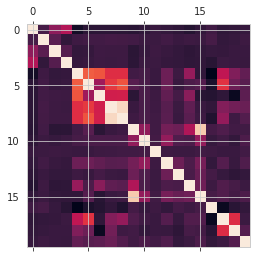

In [89]:
corr = corrdf.corr(method='pearson')
plt.matshow(corrdf.corr(method='pearson'))

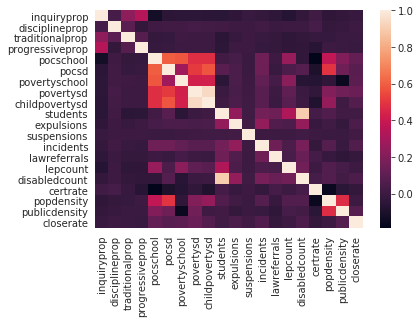

In [90]:
corr = corrdf.corr(method='pearson')
heatcorr = sns.heatmap(corr, 
                       xticklabels=corr.columns.values,
                       yticklabels=corr.columns.values)

heatcorr

In [91]:
fig = heatcorr.get_figure()
fig.savefig("../../Charter-school-identities/data/heatcorr_current.png")